In [2]:
import trackhhl.toy.simple_generator as toy
import numpy as np

### Detector Geometry

In [3]:
N_MODULES = 3
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)]
)

detector

SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0])

### Particle Generator


In [4]:
generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/6
)
generator

SimpleGenerator(detector_geometry=SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0]), primary_vertices=[], phi_min=0.0, phi_max=6.283185307179586, theta_min=0.0, theta_max=0.5235987755982988, rng=Generator(PCG64) at 0x109AF09E0)

In [5]:
N_PARTICLES = 3
event = generator.generate_event(N_PARTICLES)
event.hits

[Hit(hit_id=0, x=np.float64(0.5310167307309791), y=np.float64(-0.15186764768774583), z=1.0, module_id=0, track_id=0),
 Hit(hit_id=3, x=np.float64(-0.10518326652577707), y=np.float64(-0.29040827163224037), z=1.0, module_id=0, track_id=1),
 Hit(hit_id=6, x=np.float64(0.47906932244933287), y=np.float64(-0.2003471791764583), z=1.0, module_id=0, track_id=2),
 Hit(hit_id=1, x=np.float64(1.0620334614619582), y=np.float64(-0.30373529537549165), z=2.0, module_id=1, track_id=0),
 Hit(hit_id=4, x=np.float64(-0.21036653305155414), y=np.float64(-0.5808165432644807), z=2.0, module_id=1, track_id=1),
 Hit(hit_id=7, x=np.float64(0.9581386448986657), y=np.float64(-0.4006943583529166), z=2.0, module_id=1, track_id=2),
 Hit(hit_id=2, x=np.float64(1.5930501921929376), y=np.float64(-0.45560294306323756), z=3.0, module_id=2, track_id=0),
 Hit(hit_id=5, x=np.float64(-0.3155497995773312), y=np.float64(-0.871224814896721), z=3.0, module_id=2, track_id=1),
 Hit(hit_id=8, x=np.float64(1.4372079673479987), y=np.f

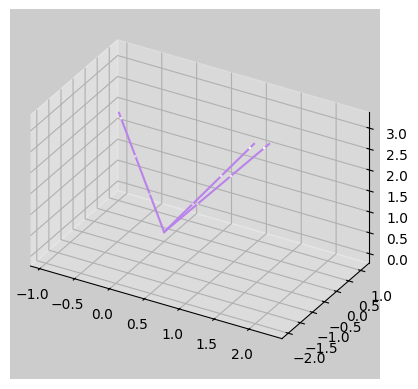

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
event.display(ax)
plt.show()